In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [2]:
filter_size1 = 5
num_filters1 = 16
filter_size2 = 5
num_filters2 = 36
fc_size = 128    
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


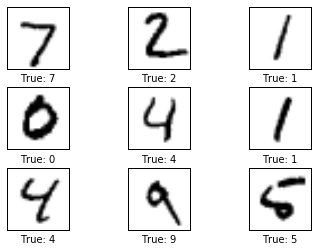

In [4]:
data.test.cls = np.argmax(data.test.labels, axis=1)
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_channels = 1
num_classes = 10
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
images = data.test.images[0:9]
cls_true = data.test.cls[0:9]
plot_images(images=images, cls_true=cls_true)

In [5]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))
def new_conv_layer(input,              
                   num_input_channels, 
                   filter_size,       
                   num_filters,        
                   use_pooling=True):  
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    layer += biases
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    layer = tf.nn.relu(layer)
    return layer, weights
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features
def new_fc_layer(input,          
                 num_inputs,     
                 num_outputs, 
                 use_relu=True): 
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
layer_flat, num_features = flatten_layer(layer_conv2)
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [6]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [9]:
session = tf.Session()
session.run(tf.global_variables_initializer())
train_batch_size = 64
total_iterations = 0

def optimize(num_iterations):
    global total_iterations
    start_time = time.time()
    for i in range(total_iterations,
                   total_iterations + num_iterations):
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)
        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i + 1, acc))
    total_iterations += num_iterations
    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
def plot_confusion_matrix(cls_pred):
    cls_true = data.test.cls
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    print(cm)
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):
    num_test = len(data.test.images)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    
    i = 0
    
    while i < num_test:
        j = min(i + test_batch_size, num_test)
        images = data.test.images[i:j, :]
        labels = data.test.labels[i:j, :]
        feed_dict = {x: images,
                     y_true: labels}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j
    cls_true = data.test.cls
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [10]:
print_test_accuracy()

Accuracy on Test-Set: 9.0% (903 / 10000)


In [11]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:  10.9%
Time usage: 0:03:05


In [12]:
print_test_accuracy()

Accuracy on Test-Set: 9.7% (972 / 10000)


In [13]:
optimize(num_iterations=99)

Time usage: 0:01:00


Accuracy on Test-Set: 72.5% (7246 / 10000)
Example errors:


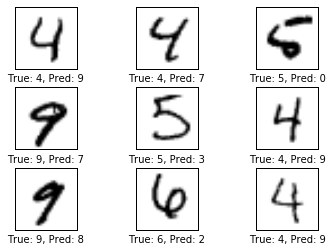

In [14]:
print_test_accuracy(show_example_errors=True)

In [15]:
optimize(num_iterations=900)

Optimization Iteration:    101, Training Accuracy:  65.6%
Optimization Iteration:    201, Training Accuracy:  87.5%
Optimization Iteration:    301, Training Accuracy:  90.6%
Optimization Iteration:    401, Training Accuracy:  87.5%
Optimization Iteration:    501, Training Accuracy:  85.9%
Optimization Iteration:    601, Training Accuracy:  89.1%
Optimization Iteration:    701, Training Accuracy:  93.8%
Optimization Iteration:    801, Training Accuracy:  96.9%
Optimization Iteration:    901, Training Accuracy:  89.1%
Time usage: 0:08:50


Accuracy on Test-Set: 93.5% (9355 / 10000)
Example errors:


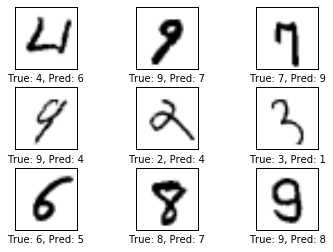

In [16]:
print_test_accuracy(show_example_errors=True)

In [17]:
optimize(num_iterations=9000)

Optimization Iteration:   1001, Training Accuracy:  93.8%
Optimization Iteration:   1101, Training Accuracy:  95.3%
Optimization Iteration:   1201, Training Accuracy:  98.4%
Optimization Iteration:   1301, Training Accuracy:  89.1%
Optimization Iteration:   1401, Training Accuracy:  93.8%
Optimization Iteration:   1501, Training Accuracy:  96.9%
Optimization Iteration:   1601, Training Accuracy: 100.0%
Optimization Iteration:   1701, Training Accuracy:  93.8%
Optimization Iteration:   1801, Training Accuracy:  98.4%
Optimization Iteration:   1901, Training Accuracy:  96.9%
Optimization Iteration:   2001, Training Accuracy:  95.3%
Optimization Iteration:   2101, Training Accuracy:  96.9%
Optimization Iteration:   2201, Training Accuracy:  96.9%
Optimization Iteration:   2301, Training Accuracy:  96.9%
Optimization Iteration:   2401, Training Accuracy:  95.3%
Optimization Iteration:   2501, Training Accuracy: 100.0%
Optimization Iteration:   2601, Training Accuracy:  96.9%
Optimization I

Accuracy on Test-Set: 98.5% (9850 / 10000)
Example errors:


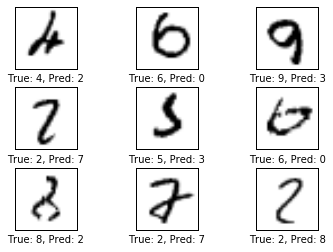

Confusion Matrix:
[[ 974    0    1    0    0    0    1    1    3    0]
 [   0 1126    1    2    0    0    2    1    3    0]
 [   2    2 1017    2    0    0    0    3    6    0]
 [   1    0    0  999    0    5    0    3    2    0]
 [   0    0    2    0  968    0    1    3    0    8]
 [   2    1    0    7    0  880    1    0    1    0]
 [   8    3    0    1    2    5  939    0    0    0]
 [   1    3    5    3    0    0    0 1014    2    0]
 [   3    0    1    1    1    1    1    2  962    2]
 [   4    4    0   12    5    4    0    6    3  971]]


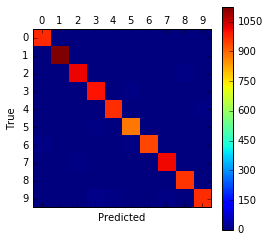

In [18]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)